In [2]:
library(AppliedPredictiveModeling)
set.seed(975)
trn <- quadBoundaryFunc(500)
vld <- quadBoundaryFunc(1000)
head(trn)

X1,X2,prob,class
2.4685709,2.28742015,0.9647251,Class1
-0.1889407,-1.63949455,0.9913938,Class1
-1.9101460,-2.89194964,1.0000000,Class1
0.3481279,0.06707434,0.1529697,Class1
0.1401153,0.86900555,0.5563062,Class1
0.7717148,-0.91504835,0.2713248,Class2


Warning message in barchart.table(table(x), data, ...):
"explicit 'data' specification ignored"

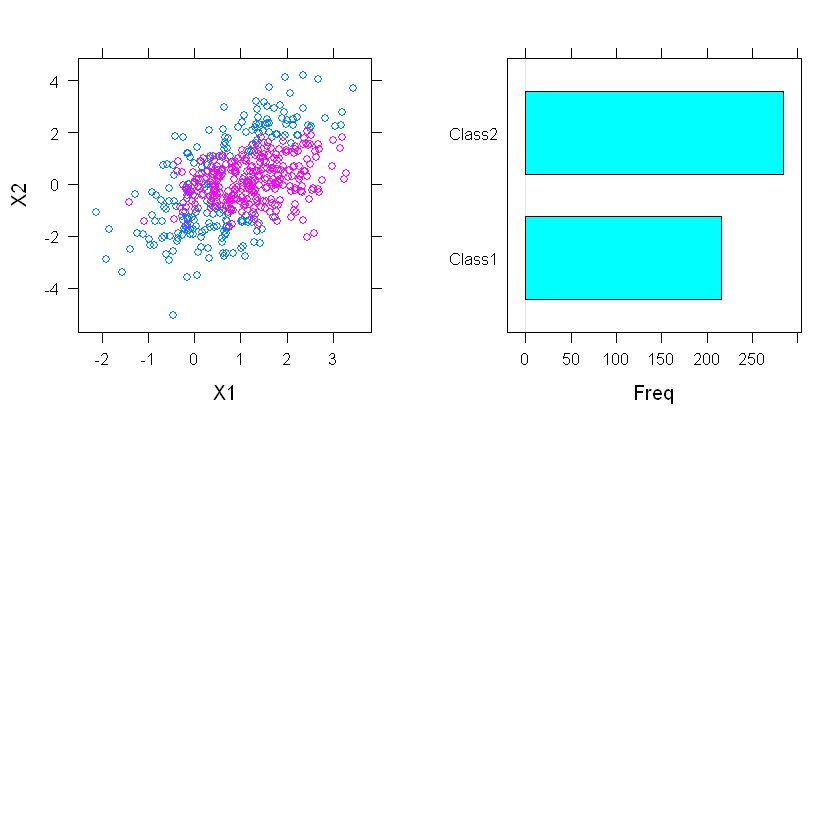

In [3]:
library(lattice)
library(gridExtra)
p1 <- xyplot(X2~X1,data=trn,groups = class)
p2 <- barchart(trn$class,data=trn)
grid.arrange(p1,p2,ncol=2,nrow=2)

# table(trn$class)
# p1 <- ggplot(data=trn,aes(X1,X2,colour=class)) + geom_point() + theme_stata() + scale_color_tableau() + theme(legend.position = "top")

In [4]:
library(randomForest)
fit_rf <- randomForest(class~X1+X2,data=trn,ntree=2000)
fit_rf

library(MASS)
fit_qda <- qda(class~X1+X2,data=trn)
fit_qda

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:gridExtra':

    combine




Call:
 randomForest(formula = class ~ X1 + X2, data = trn, ntree = 2000) 
               Type of random forest: classification
                     Number of trees: 2000
No. of variables tried at each split: 1

        OOB estimate of  error rate: 15.4%
Confusion matrix:
       Class1 Class2 class.error
Class1    174     42   0.1944444
Class2     35    249   0.1232394

Call:
qda(class ~ X1 + X2, data = trn)

Prior probabilities of groups:
Class1 Class2 
 0.432  0.568 

Group means:
              X1          X2
Class1 0.5881427 -0.05429687
Class2 1.2342071  0.11753625

In [5]:
pred_qda <- predict(fit_qda,trn)
trn$qda_prob <- pred_qda$posterior[,"Class1"]

pred_vld_qda <- predict(fit_qda,newdata = vld)
vld$qda_prob <- pred_vld_qda$posterior[,"Class1"]

In [6]:
#rf
pred_vld_rf <- predict(fit_rf,vld,type="prob")
vld$rf_prob <- pred_vld_rf[,"Class1"]
vld$rf_cls <- predict(fit_rf,vld)

In [7]:
head(vld)

X1,X2,prob,class,qda_prob,rf_prob,rf_cls
0.6689362,-0.9113505,0.31729132,Class2,0.3830767,0.4440,Class2
-0.1149877,-0.8272760,0.64476405,Class1,0.5440393,0.5355,Class1
1.2704375,2.9100370,0.99999790,Class1,0.9846107,0.9935,Class1
-0.5511148,-0.2145599,0.53333948,Class2,0.5463540,0.9330,Class1
0.9566129,-0.3315233,0.05333099,Class2,0.2426705,0.0170,Class2
-0.2132386,0.2364065,0.38441722,Class2,0.4823296,0.2840,Class2


In [8]:
#Sensitivity & Specificity
#Sensitivity= TP / (TP + FN) 
library(caret)
sensitivity(
            data=vld$rf_cls,
           reference=vld$class,
           positive="Class1")
#Specificity=TNR = TN / (TN + FP)    
specificity(
           data=vld$rf_cls,
           reference=vld$class,
           negative="Class2")

Loading required package: ggplot2

Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin



[1] 0.8257081

[1] 0.8983364

In [9]:
prop.table(table(vld$class))


Class1 Class2 
 0.459  0.541 

```r
# ?posPredValue
#https://onlinecourses.science.psu.edu/stat507/node/71/
# PPV=(sensitivity∗Prevalence)/((sensitivity∗Prevalence)+((1−specificity)∗(1−Prevalence)))
# NPV=(specificity∗(1−Prevalence))/(((1−sensitivity)∗Prevalence)+((specificity)∗(1−Prevalence)))
```

In [10]:
posPredValue(
            data=vld$rf_cls,
            reference=vld$class,
            positive="Class1")

negPredValue(
            data=vld$rf_cls,
            reference=vld$class,
            positive="Class2")

posPredValue(
             data=vld$rf_cls,
             reference=vld$class,
             positive="Class1",
             prevalence=.9)

[1] 0.8732719

[1] 0.8586572

[1] 0.9865043

In [11]:
#ConfusionMatrix
confusionMatrix(
               data=vld$rf_cls,
               reference=vld$class,
               positive="Class1")

Confusion Matrix and Statistics

          Reference
Prediction Class1 Class2
    Class1    379     55
    Class2     80    486
                                          
               Accuracy : 0.865           
                 95% CI : (0.8422, 0.8856)
    No Information Rate : 0.541           
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.727           
 Mcnemar's Test P-Value : 0.03887         
                                          
            Sensitivity : 0.8257          
            Specificity : 0.8983          
         Pos Pred Value : 0.8733          
         Neg Pred Value : 0.8587          
             Prevalence : 0.4590          
         Detection Rate : 0.3790          
   Detection Prevalence : 0.4340          
      Balanced Accuracy : 0.8620          
                                          
       'Positive' Class : Class1          
                                          

In [12]:
#ROC curves
# install.packages("pROC")
library(pROC)
roc_curve <- roc(
                 response = vld$class,
                predictor = vld$rf_prob,
                levels=rev(levels(vld$class)))

Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



In [13]:
auc(roc_curve)

Area under the curve: 0.9335

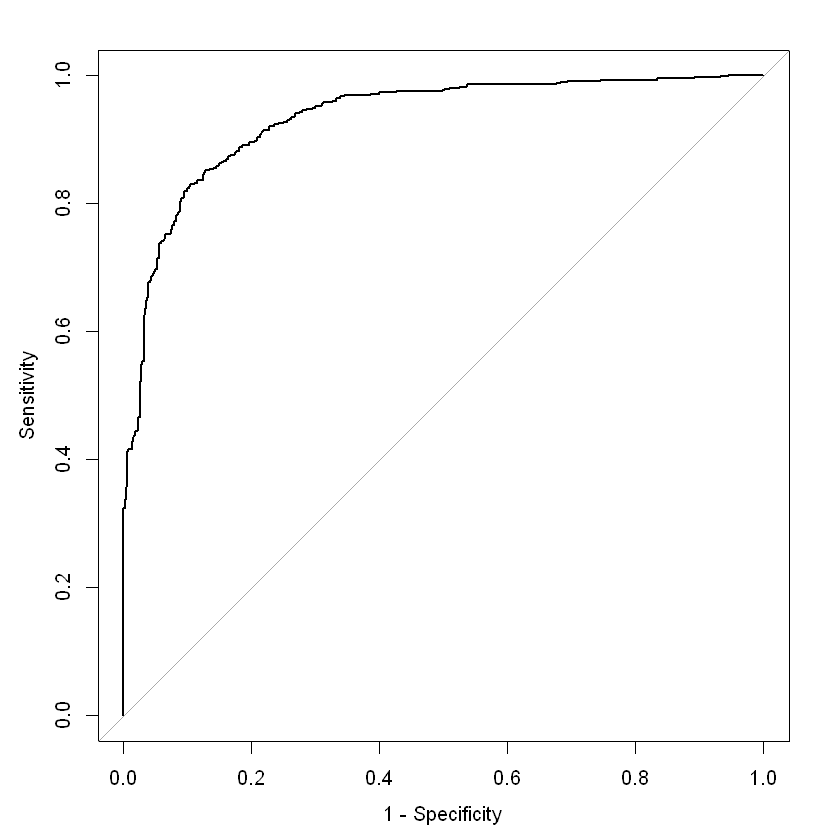

In [14]:
plot(roc_curve,legacy.axes=T)

In [15]:
#lift charts
# names(vld)
labs <- c(qda_prob="QDA",rf_prob="RF")
lift_curve <- lift(class~qda_prob+rf_prob,data=vld,labels=labs)
lift_curve


Call:
lift.formula(x = class ~ qda_prob + rf_prob, data = vld, labels = labs)

Models: QDA, RF 
Event: Class1 (45.9%)

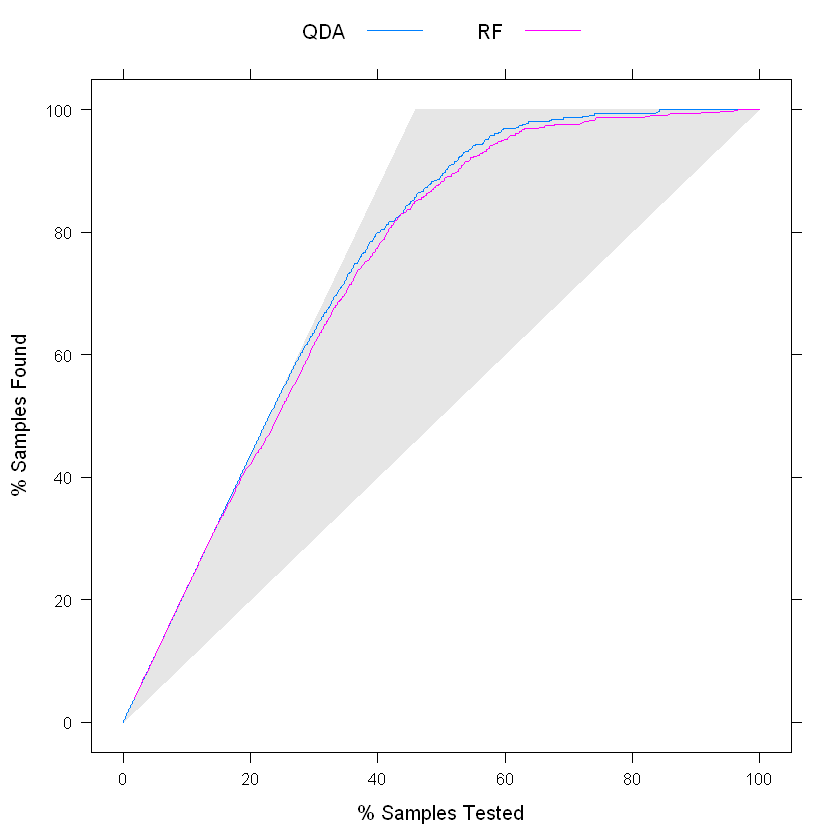

In [16]:
xyplot(lift_curve,auto.key=list(columns=2,lines=T,points=F))

In [17]:
#Calibrating Probabilities
cal_curve <- calibration(class~qda_prob+rf_prob,data=vld)
cal_curve


Call:
calibration.formula(x = class ~ qda_prob + rf_prob, data = vld)

Models: qda_prob, rf_prob 
Event:  Class1 
Cuts: 11 

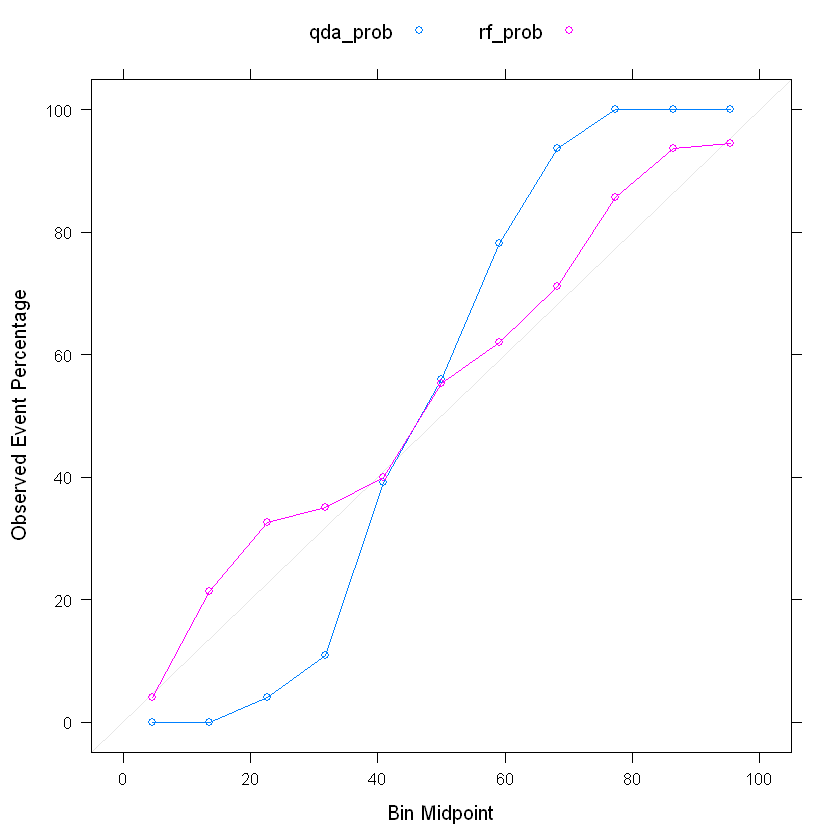

In [18]:
xyplot(cal_curve,auto.key=list(columns=2))

`calibration.plot in gbm package`

In [19]:
sigmodial_cal <- glm(relevel(class,ref="Class2")~qda_prob,
              data=trn,family=binomial)
coef(summary(sigmodial_cal))

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-5.701055,0.5005652,-11.38924,4.731132e-30
qda_prob,11.717292,1.0705197,10.94542,6.989017e-28


In [20]:
sigmodial_prob <- predict(
                          sigmodial_cal,
                          newdata = vld[,"qda_prob",drop=F],
                         type="response")
vld$qda_sigmodial <- sigmodial_prob

In [21]:
library(klaR)
bayes_cal <- NaiveBayes(class~qda_prob,data=trn,usekernel=T)

bayes_prob <- predict(
                     bayes_cal,
                     newdata=,vld[,"qda_prob",drop=F])
vld$qda_bayes <- bayes_prob$posterior[,"Class1"]

In [22]:
head(vld[,c(5:6,8,9)])

qda_prob,rf_prob,qda_sigmodial,qda_bayes
0.3830767,0.4440,0.22927068,0.2515696
0.5440393,0.5355,0.66231139,0.6383383
0.9846107,0.9935,0.99708776,0.9995061
0.5463540,0.9330,0.66835048,0.6430232
0.2426705,0.0170,0.05428903,0.0566883
0.4823296,0.2840,0.48763794,0.5109129


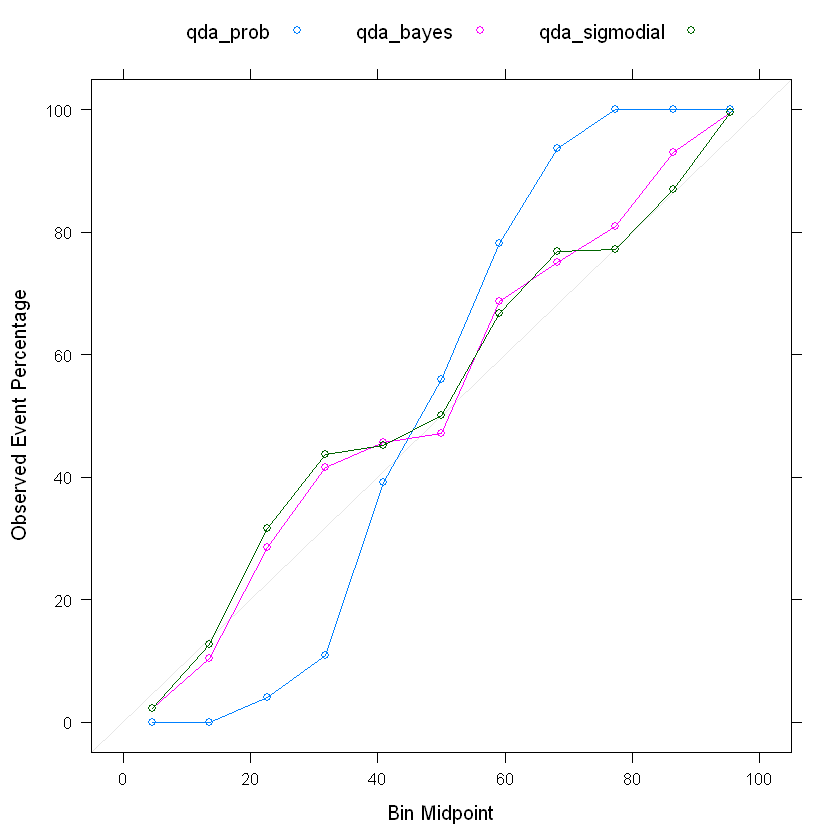

In [23]:
cal_curve_2 <- calibration(class~qda_prob+qda_bayes+qda_sigmodial,
                          data=vld)
xyplot(cal_curve_2,auto.key = list(columns=3))

Ref: 
https://onlinecourses.science.psu.edu/stat507/node/71/

&#x1F4AC; Notes

> Consider an insurance company that wants to uncover and prosecute fraudulent claims. Using historical claims data, a classification model could be built to predict the probability of claim fraud. This probability would then be combined with the company’s investigation costs and potential onetary loss to determine if pursuing the investigation is `in the best financial interest` of the insurance company. 

### Evaluating Predictied Classes
- Evaluating Predictied Classes
    - Confusion Matrix
        - overall accuracy rate
     - No-information rate
     - Kappa

$$Kappa=\frac{O-E}{1-E}$$

$$Observed Accuracy = \frac{TP+TN}{ALL}$$
$$Expected Accuracy = \frac{(TP+FN)*(TP+FP)}{N^2} + \frac{(TN+FN)*(TN+FP)}{N^2}$$

#### Two-Class Problems

| Confusion Matrix | Obs_P | Obs_N |
| :------| ------: | :------: |
| Pred_P | TP | FP |
| Pred_N | FN | TN |

$$ Sensitivity = \frac{TP}{TP+FN}$$

$$ Specificity = \frac{TN}{FP+TN}$$

$$ FPR = 1-Specificity = \frac{FP}{FP+TN}$$

\begin{example}

| Confusion Matrix | Good | Bad |
| :------| ------: | :------: |
| Good | TP=130 | FP=36 |
| Bad | FN=10 | TN=24 |

\end{example}

`Example 1 : Choose the event of interest to be a customer with Good credit`

$OverallAccuracy = \frac{TP}{TP+FP}=\frac{130}{130+36}=0.78$

$No-infomative Rate = \frac{TP+NF}{ALL} = \frac{130+10}{200}=0.70$

$O = \frac{TP+TN}{ALL} = \frac{130+24}{200}=$

$Expected Accuracy = \frac{(TP+FN)*(TP+FP)}{N^2} + \frac{(TN+FN)*(TN+FP)}{N^2}=\frac{(130+10)*(130+36)}{200^2}+\frac{(21+10)(24+36)}{200^2}$

$Kappa=\frac{O-E}{1-E}=0.76$

\begin{example}

| Confusion Matrix | Bad | Good |
| :------| ------: | :------: |
| Bad | TP=24 | FP=10 |
| Good | FN=36 | TN=130 |

\end{example}

`Example 2 : Choose the event of interest to be a customer with Bad credit`

$OverallAccuracy = \frac{TP}{TP+FP}=\frac{24}{24+10}=0.71$

$No-infomative Rate = \frac{TP+NF}{ALL} = \frac{24+36}{200}=0.30$

$ Sensitivity = \frac{TP}{TP+FN}= \frac{24}{24+36} = 0.4$

$ Specificity = \frac{TN}{FP+TN}  = \frac{130}{130+10} = 0.93$

$$PPV(Positive Predictive Value)=\frac{Sensitivity*Prevalence}{Sensitivity*Prevalence+(1-Specificity)*(1-Prevalence)}$$

$$NPV(Positive Predictive Value)=\frac{Specificity*(1-Prevalence)}{(1-Sensitivity)*Prevalence+Specificity*(1-Prevalence)}$$

`When prevalence=0.5`
$$PPV(Positive Predictive Value)=\frac{TP}{TP+FP}$$

$$NPV(Negative Predictive Value)=\frac{TN}{TN+FN}$$

### &#x1F389; Non-Accuracy-Based Criteria
`this part is very enlightening`

### Evaluating Class Probabilities
#### ROC curves
> One advantage of using ROC curves to characterize models is that, since it is a function of sensitivity and specificity, the curve is insensitive to disparities in the class proportions (Provost et al. 1998; Fawcett 2006). A disadvantage of using the area under the curve to evaluate models is that it obscures information. 
#### Lift Charts
> Lift charts (Ling and Li 1998) are a visualization tool for assessing the ability of a model to detect events in a data set with two classes.